<a href="https://colab.research.google.com/github/OmerElshrief/Automated-interpretation-of-knee-MRs/blob/master/MRInet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Dependencies 

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, Dropdown, IntSlider
%matplotlib inline
plt.style.use('grayscale')
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import torchvision.models as models
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import PIL
from PIL import Image


PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### unzipping

In [0]:
!unzip -qq "drive/My Drive/MRNet-v1.0.zip" -d "drive/My Drive/Pattern Assignments/MRI-Ass4"


## Loading the Data

In [0]:

# interactive viewer
class KneePlot():
    def __init__(self, x, figsize=(10, 10)):
        self.x = x
        self.planes = list(x.keys())
        self.slice_nums = {plane: self.x[plane].shape[0] for plane in self.planes}
        self.figsize = figsize
    
    def _plot_slices(self, plane, im_slice): 
        fig, ax = plt.subplots(1, 1, figsize=self.figsize)
        ax.imshow(self.x[plane][im_slice, :, :])
        plt.show()
    
    def draw(self):
        planes_widget = Dropdown(options=self.planes)
        plane_init = self.planes[0]
        slice_init = self.slice_nums[plane_init] - 1
        slices_widget = IntSlider(min=0, max=slice_init, value=slice_init//2)
        def update_slices_widget(*args):
            slices_widget.max = self.slice_nums[planes_widget.value] - 1
            slices_widget.value = slices_widget.max // 2
        planes_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices, plane=planes_widget, im_slice=slices_widget)
    
    def resize(self, figsize): self.figsize = figsize

# example usage
#plot = KneePlot(x, figsize=(8, 8))
#plot.draw()

In [0]:
data_path = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0'
train_data_path = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/train'
dev_data_path = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/valid'
#views = {'axial': np.array(), 
#         'coronal': np.array(), 
#         'sagittal': np.array()}

train_abnormal = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/train-abnormal.csv'
train_acl = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/train-acl.csv'
train_meniscus = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/train-meniscus.csv'

valid_abnormal = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/valid-abnormal.csv'
valid_acl = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/valid-acl.csv'
valid_meniscus = 'drive/My Drive/Pattern Assignments/MRI-Ass4/MRNet-v1.0/valid-meniscus.csv'

# data loading functions

def load_one_stack(case, data_path=train_data_path, plane='coronal'):
    fpath = data_path+'/'+plane+'/'+'{}.npy'.format(case)
    #print(fpath)
    return np.load(fpath)

def load_stacks(case, data_path=train_data_path):
    x = {}
    # We may just use 1 plane for each CNN because The Data is consuming all the Ram
    #planes = ['coronal', 'sagittal', 'axial']
    planes = ['sagittal'] #First we start with the Coronal plane
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane,data_path=data_path)
    return x
  

#### Loading the Labels


In [0]:

train_abnl_labels = pd.read_csv(train_abnormal, header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl_labels = pd.read_csv(train_acl, header=None,
                       names=['Case_acl', 'ACL'], 
                       dtype={'Case_acl': str, 'ACL': np.int64})

train_meniscus_labels = pd.read_csv(train_meniscus, header=None,
                       names=['Case_men', 'Meniscus'], 
                       dtype={'Case_men': str, 'Meniscus': np.int64})


labels = [train_abnl_labels, train_acl_labels, train_meniscus_labels]
labels= pd.concat(labels, axis = 1)
labels.drop(columns=['Case_acl','Case_men'],inplace = True)
print("train_Labels loaded")

train_Labels loaded


In [0]:
# Loading the Data
cases_size = 1130
train_data = []

for i in range(0,cases_size):
  case = train_abnl_labels.Case[i]
  stacks = load_stacks(case)
  train_data.append((stacks))
  
print("Train Data loaded")

KeyboardInterrupt: ignored

In [0]:
plot = KneePlot(train_data[1], figsize=(8, 8))
plot.draw()

interactive(children=(Dropdown(description='plane', options=('sagittal',), value='sagittal'), IntSlider(value=…

In [0]:
x = torch.from_numpy(get_mean_threshold(train_data[30]['sagittal']))
print(x.shape)
globalMaxPool = nn.AdaptiveAvgPool3d(output_size = (1,256,256))
x=x.reshape(1,-1,256,256)
out = globalMaxPool(x)
out.shape

In [0]:
out = out.reshape(256,256)
plt.imshow(out)

## Load Validation Data

In [0]:

valid_abnl_labels = pd.read_csv(valid_abnormal, header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

valid_acl_labels = pd.read_csv(valid_acl, header=None,
                       names=['Case_acl', 'ACL'], 
                       dtype={'Case_acl': str, 'ACL': np.int64})

valid_meniscus_labels = pd.read_csv(valid_meniscus, header=None,
                       names=['Case_men', 'Meniscus'], 
                       dtype={'Case_men': str, 'Meniscus': np.int64})


valid_labels = [valid_abnl_labels, valid_acl_labels, valid_meniscus_labels]
valid_labels= pd.concat(valid_labels, axis = 1)
valid_labels.drop(columns=['Case_acl','Case_men'],inplace = True)
print("valid_labels loaded")

#### Load validation Data

In [0]:

# Loading the Data
cases_size = 120
valid_data = []

for i in range(0,cases_size):
  case = valid_abnl_labels.Case[i]
  stacks = load_stacks(case,data_path =dev_data_path )
  
  valid_data.append((stacks['sagittal']))
valid_data = np.array(valid_data)
print('validation_data Loaded')


In [0]:
img = get_lablacian_edge(train_data[1])

TypeError: ignored

# **image Processing**

#### plotting a Pre-processed Sample

In [0]:
transforms(np.array(transformed_train_data.data.numpy(),dtype = np.uint8))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [0]:
m = get_3ch(train_data[780])
plt.subplot(131),plt.imshow(m[0])
plt.subplot(132),plt.imshow(m[1])
plt.subplot(133),plt.imshow(m[2])
plt.show()

#### Images (Slices) preprocessing class

In [0]:
def get_mean_threshold(stack):
  out_stack = []
  for img in stack:
    #img = cv2.fastNlMeansDenoising()

    img = cv2.medianBlur(img,5)

    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    out_stack.append(img)
  return np.array(out_stack, dtype= np.float32)

def get_canny_edges(stack):
  out_stack = []
  for img in stack:
    img = cv2.fastNlMeansDenoising(img,None,10)
    img = cv2.GaussianBlur(img,(5,5),0)

    img = cv2.Canny(img,100,200)
    out_stack.append(img)
  return np.array(out_stack, dtype= np.float32) 

def get_lablacian_edge(stack):
  out_stack = []
  for img in stack:
    img = cv2.fastNlMeansDenoising(img,None,10)
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.Laplacian(img,cv2.CV_8U)
    out_stack.append(img)
  return np.array(out_stack, dtype= np.float32) 



def get_adabtive_avg_pooling(stack , plot = False):
  x = torch.from_numpy(stack)
  globalMaxPool = nn.AdaptiveAvgPool3d(output_size = (1,256,256))
  x=x.reshape(1,-1,256,256)
  out = globalMaxPool(x)
  out = out.reshape(256,256)
  if plot == True:
    plt.imshow(out)
  return out


def get_3ch(stck):
  ch1 = get_adabtive_avg_pooling( get_canny_edges(stck) )
  ch2 = get_adabtive_avg_pooling( get_lablacian_edge(stck))
  ch3 = cv2.medianBlur(stck[int(len(stck)/2)],5)

  return np.stack([ch1,ch2,ch3], axis = 0)

def fit_transform(self,data):

  transformed_data = []
  for stck in data:

    transformed_data.append(get_3ch(stck)) 
  return torch.tensor(transformed_data)

In [0]:
class Preprocessor:
  
    
    
  def get_mean_threshold(self,stack):
    out_stack = []
    for img in stack:
      #img = cv2.fastNlMeansDenoising()

      img = cv2.medianBlur(img,5)

      img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
              cv2.THRESH_BINARY,11,2)
      out_stack.append(img)
    return np.array(out_stack, dtype= np.float32)

  def get_canny_edges(self,stack):
    out_stack = []
    for img in stack:
     # img = cv2.fastNlMeansDenoising(img,None,10)
      img = cv2.GaussianBlur(img,(5,5),0)

      img = cv2.Canny(img,100,200)
      img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
      out_stack.append(img)
    return np.array(out_stack, dtype= np.float32) 

  def get_lablacian_edge(self,stack):
    out_stack = []
    for img in stack:
      #mg = cv2.fastNlMeansDenoising(img,None,10)
      img = cv2.GaussianBlur(img,(5,5),0)
      img = cv2.Laplacian(img,cv2.CV_8U)
      img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      out_stack.append(img)
    return np.array(out_stack, dtype= np.float32) 



  def get_adabtive_avg_pooling(self,stack , plot = False):
    x = torch.from_numpy(stack)
    globalMaxPool = nn.AdaptiveAvgPool3d(output_size = (1,256,256))
    x=x.reshape(1,-1,256,256)
    out = globalMaxPool(x)
    out = out.reshape(256,256)
    if plot == True:
      plt.imshow(out)
    return out


  def get_3ch(self,stck):
    #ch1 = self.get_adabtive_avg_pooling( self.get_canny_edges(stck) )
    #ch1 = cv2.normalize(ch1.data.numpy(), None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) 
    #ch2 = self.get_adabtive_avg_pooling( self.get_lablacian_edge(stck))
    #ch1 = cv2.normalize(stck[int(len(stck)/2)+1],None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #ch2 = cv2.normalize(stck[int(len(stck)/2)],None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #ch3 = cv2.normalize(stck[int(len(stck)/2)-1] , None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ch3 = self.get_adabtive_avg_pooling(np.array((stck),dtype = np.float32))
    ch3 = cv2.normalize(ch3.data.numpy(), None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #ch3 = cv2.normalize(ch3.data.numpy(), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                              
    return ch3
    #return np.stack([ch1,ch2,ch3], axis = 0)

  def fit_transform(self,data):
    
    transformed_data = []
    for stck in data:
      
      transformed_data.append(self.get_3ch(stck)) 
    return torch.tensor(transformed_data)

In [0]:
img = train_data[1][1]
norm_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

### Transformation Functions

##### For data Augmentation

*   Resizing to 224x224
*   Random Horizontal flip
*   Random Rotatation
*   Color Jitter
*  Convert to RGP



In [0]:
transforms = torchvision.transforms.Compose([
    
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor()
])

validation_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()
])

def ToRGB(x):
  x.unsqueeze_(0)
  x = x.repeat(3, 1, 1)
  return x

def data_augmentation_transform(train_data,validate = False):
  transformed_augmanted_train_data = []
  for img in train_data:
    
    if validate:
      x = validation_transform(img).reshape(224,224)
    else:
      x = transforms(img).reshape(224,224)
        
    x = cv2.normalize(x.data.numpy(), None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    x = ToRGB(torch.from_numpy(x))
    transformed_augmanted_train_data.append(torch.tensor(x))
  return torch.stack(transformed_augmanted_train_data)

In [0]:


#x = x.reshape(224,224)
x = transforms(transformed_train_data)
transformed_train_data.shape

torch.Size([1130, 256, 256])

# Building a Model based on the Pre-processed Data
For later uses, to enhance the results of the base mode

### Getting the Pretrined models

In [0]:
model_alexNet  = models.alexnet(pretrained=True)
model_Resnet   = models.resnet18(pretrained=True)
model_denseNet = models.densenet121(pretrained=True)

### Helper Fucntions


In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
      for param in model.parameters():
            param.requires_grad = True
      
    
      
def create_optimizer(model , r = 0.0001):
  params_to_update = model.parameters()
  print("Params to learn:")
  
  params_to_update = []
  for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
        
  return  optim.Adam(params_to_update, lr=r)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
       
      
      
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
      
class Transform(nn.Module):
  def __init__(self):
    super(Transform, self).__init__()
  
  def forward(self,x):
    return transforms(x)
        

In [0]:
num_ftrs = model_denseNet.classifier.in_features

### DensetNet

In [0]:


class DenseNet_Model (nn.Module):
  def __init__(self):
    
        super().__init__()
        
        
        self.dense = model_denseNet.features
        set_parameter_requires_grad(self.dense,True)
        set_parameter_requires_grad(self.dense[10].denselayer15,False)
        set_parameter_requires_grad(self.dense[10].denselayer16,False)
        #num_ftrs = model_denseNet.classifier.in_features
       
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(num_ftrs*2 ,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(num_ftrs*2 , 256)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)
        self.out = nn.Sigmoid()
        

  def forward(self, x):
       
        #print(x.shape)
        x = self.dense(x)
        #print(x.shape)
        ap = self.avgpool(x)
        mp = self.maxpool(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        
        x = self.bn0(x)
        x = self.dropout0(x)
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        
        
        return self.out(x)

  def __call__(self, x): return self.forward(x)
  
feature_extraction_model = DenseNet_Model()
feature_extraction_model.to(device)
#print(feature_extraction_model)
summary(feature_extraction_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

### AlexNet

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class MRModel (nn.Module):
  def __init__(self):
    
        super().__init__()
        
        self.features_extractor = model_alexNet.features
        #set_parameter_requires_grad(self.features_extractor,True)
        self.features_extractor[10] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_extractor[8] = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(512 ,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(512 , 256)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 1)
        self.out = nn.Sigmoid()
        

  def forward(self, x):
        
        x = self.features_extractor(x)
       
        ap = self.avgpool(x)
        mp = self.maxpool(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        
        x = self.bn0(x)
        x = self.dropout0(x)
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        
        
        return self.out(x)

  def __call__(self, x): return self.forward(x)
  
feature_extraction_model = MRModel()
feature_extraction_model.to(device)
print(feature_extraction_model)
summary(feature_extraction_model,(3,224,224))

MRModel(
  (features_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (maxpool): AdaptiveMaxPool2d(output_size=1)
  (fla): Flatten()
  (bn0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

### Resnet18

```

```



In [0]:
num_ftrs = model_Resnet.fc.in_features

In [0]:

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class Flatten(nn.Module):
  def forward(self, input):
      return input.view(input.size(0), -1)


      
class Resnet_Model (nn.Module):
  def __init__(self):
    
        super().__init__()
        set_parameter_requires_grad(model_Resnet, True)
        set_parameter_requires_grad(model_Resnet.layer4, False)
        
        #num_ftrs = model_Resnet.fc.in_features
        model_Resnet.fc = Identity()
        model_Resnet.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         
        self.Resnet = model_Resnet
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(num_ftrs,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(0.6)
        self.fc1 = nn.Linear(num_ftrs, 1024)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(1024,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1)
        self.out = nn.Sigmoid()
        

  def forward(self, x):
        
        x = self.Resnet(x)
        
        #x = x.reshape(-1,1000,1,1)
        #print(x.shape)
        mp = self.maxpool(x)
        ap = self.avgpool(x)
        
        x = torch.cat((ap,mp),dim=1)
        x = self.flat(x)
        
        x = self.bn0(x)
        x = self.dropout0(x)
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        
        
        return self.out(x)

  def __call__(self, x): return self.forward(x)
  
feature_extraction_model = Resnet_Model()
feature_extraction_model.to(device)

summary(feature_extraction_model,(3,224,224))


NameError: ignored

### Training and Validation data preparation

In [0]:
# First transform the Data 
preprocessor = Preprocessor()
transformed_train_data = preprocessor.fit_transform(train_data)
transformed_valid_data = preprocessor.fit_transform(valid_data)


## Building Dataloaders
import torch.utils.data as utils
from torch.utils.data.dataset import random_split
tensor_y = torch.stack([torch.Tensor(i) for i in np.array(labels['Meniscus']).reshape(-1,1)])

my_dataset = utils.TensorDataset((transformed_train_data),tensor_y) # create your datset

train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

train_dataloader = utils.DataLoader(train_dataset,batch_size=100, shuffle=True) # create your dataloader

validate_dataloader =   utils.DataLoader(validate_dataset,batch_size=20, shuffle=False) # create your dataloader


tensor_y = torch.stack([torch.Tensor(i) for i in np.array(valid_labels['Meniscus']).reshape(-1,1)])

my_dataset = utils.TensorDataset((transformed_valid_data),tensor_y) # create your datset
test_dataloader = utils.DataLoader(my_dataset,batch_size=10, shuffle=False) # create your dataloader




### Training Function

In [0]:
def train_model(model  ,train_dataloader,valid_dataloader,NUM_EPOCHS = 100,path='drive/MyDrive/Pattern Assignments/MRI-Ass4/model.h5',lr=0.00007 ):

  classification_model = model
  classification_model.to(device)
  criterion = nn.BCELoss()
  optimizer = create_optimizer(classification_model,r =lr)
  
  j=0
  running_loss,train_correct,val_acc = 0,0,-9999
  losses = []
  accu = []
  history = []
  #print(classification_model)

  for i in range(NUM_EPOCHS):

    print('Training Epoch {} ...'.format(i+1))
    running_loss,train_correct,val_correct,val_loss = 0,0,0,0
    
    # Training for eboch
    for batch,y_true in train_dataloader:
      y_true= y_true.type(torch.FloatTensor)
      y_true = y_true.cuda()
      #print(batch.shape)
      batch = torch.stack(data_augmentation_transform(np.array(batch.data.numpy(),dtype = np.uint8)))
      batch = (batch.cuda())
      # Backward and optimize
      optimizer.zero_grad()
      y_pred = classification_model(batch)
      y_pred = y_pred.to(device)
      train_correct +=(y_true.cpu().numpy() == np.around(y_pred.cpu().detach().numpy())).sum()

#       y_true= y_true.type(torch.FloatTensor)
#       y_true = y_true.cuda()
#       y_pred = y_pred.cuda()
      loss = criterion(y_pred, y_true)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      
    ## Validaition Step for each Eboch

    print('Validating Epoch {} ...'.format(i+1)) 
    
    for batch , y_true in valid_dataloader:
        batch = torch.stack(data_augmentation_transform(np.array(batch.data.numpy(),dtype = np.uint8),validate = True))
     
        batch = batch.cuda()
        y_true= y_true.type(torch.FloatTensor)
        y_true = y_true.cuda()
       

        # Backward and optimize
        optimizer.zero_grad()
        y_pred = classification_model(batch)
        y_pred = y_pred.to(device)
       
        val_correct +=(y_true.cpu().numpy() == np.around(y_pred.cpu().detach().numpy())).sum()
        
        y_true= y_true.type(torch.FloatTensor)
        y_true = y_true.cuda()
        y_pred = y_pred.cuda()
        loss = criterion(y_pred, y_true)
        val_loss += loss.item()
       



    test_accu =  int(train_correct) / train_size
    valid_accu = int(val_correct) / test_size

    print('Train correct: ',train_correct )
    print('Tets correct: ', val_correct, 'out of: ',len(valid_dataloader))
    print ('Epoch [{}/{}], -T-Loss : {:.6f} , Train_accuracy: {:.4f} ,  Val_loss: {:.6f}  -Val_acc: {:.4f}'.format(i+1, NUM_EPOCHS,running_loss,test_accu ,val_loss, valid_accu))

    if val_acc < valid_accu:
     # torch.save(classification_model.state_dict(), path)
      print('val_acc has improved from {:.4f} to {:.4f}, model is saved at {}'.format(val_acc , valid_accu,path))
      val_acc = valid_accu
    else:
      print('val_acc has not Improved from {:.4f}'.format(val_acc))    
    history.append([i,running_loss,val_acc,val_loss])

    #accu.append(100 * int(test_correct) / len(X_test))
 
  
  print(y_pred)
  print(y_true)
  return history
    

### Traing

In [0]:
MyModel = MRModel()
MyModel.to(device)
history = train_model(MyModel ,train_dataloader,validate_dataloader,NUM_EPOCHS=20, lr = 5e-3)

Params to learn:
	 features_extractor.8.weight
	 features_extractor.8.bias
	 features_extractor.10.weight
	 features_extractor.10.bias
	 bn0.weight
	 bn0.bias
	 fc1.weight
	 fc1.bias
	 bn1.weight
	 bn1.bias
	 fc2.weight
	 fc2.bias
Training Epoch 1 ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validating Epoch 1 ...
Train correct:  509
Tets correct:  136 out of:  12
Epoch [1/20], -T-Loss : 7.005948 , Train_accuracy: 0.5631 ,  Val_loss: 7.682428  -Val_acc: 0.6018
val_acc has improved from -9999.0000 to 0.6018, model is saved at drive/MyDrive/Pattern Assignments/MRI-Ass4/model.h5
Training Epoch 2 ...
Validating Epoch 2 ...
Train correct:  583
Tets correct:  147 out of:  12
Epoch [2/20], -T-Loss : 6.623542 , Train_accuracy: 0.6449 ,  Val_loss: 7.595407  -Val_acc: 0.6504
val_acc has improved from 0.6018 to 0.6504, model is saved at drive/MyDrive/Pattern Assignments/MRI-Ass4/model.h5
Training Epoch 3 ...
Validating Epoch 3 ...
Train correct:  579
Tets correct:  150 out of:  12
Epoch [3/20], -T-Loss : 6.530936 , Train_accuracy: 0.6405 ,  Val_loss: 7.552515  -Val_acc: 0.6637
val_acc has improved from 0.6504 to 0.6637, model is saved at drive/MyDrive/Pattern Assignments/MRI-Ass4/model.h5
Training Epoch 4 ...
Validating Epoch 4 ...
Train correct:  576
Tets correct:  150 out of:  12
E

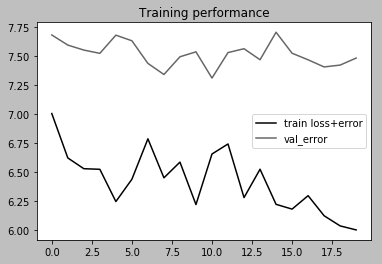

In [0]:
history = np.array(history)
plt.figure()
plt.title('Training performance')
plt.plot(history[:,0], history[:,1], label='train loss+error')
plt.plot(history[:,0], history[:,3], label='val_error')
plt.legend()

### Validation Step

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Accuracy : 56.6667 %


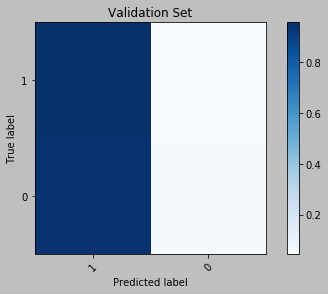

In [0]:
x = torch.stack(data_augmentation_transform(np.array(transformed_valid_data.data.numpy(),dtype = np.uint8)))
test_Y_i_hat =  MyModel((x).cuda())
test_Y_i = tensor_y
#print(test_Y_i_hat)
val_correct =(test_Y_i.cpu().numpy() == np.around(test_Y_i_hat.cpu().detach().numpy())).sum()

print("Test Accuracy : {:.4f} %".format(100 * (val_correct / 120)))
conf = np.zeros([2,2])
confnorm = np.zeros([2,2])
for i in range(0,120):
    j = int(np.around(test_Y_i[i].cpu().detach().numpy())[0])
    k = int(np.around(test_Y_i_hat[i].cpu().detach().numpy())[0])
   
    conf[j,k] = conf[j,k] + 1
for i in range(0,2):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i])
plt.figure()
plot_confusion_matrix(confnorm, labels=['1','0'], title="Validation Set")


## Preprocessing Trials 

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
out = np.array(out,dtype = np.uint8)

img = train_data[12]['sagittal'][30]
print(img.shape)
img =cv2.GaussianBlur(img,(5,5),0)
plt.imshow(img)

laplacian = cv2.Laplacian(img,cv2.CV_8U)
sobelx = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [0]:
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [0]:
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [0]:
# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
plt.imshow(blur)

# Building Kers model 

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout

#from keras.layers import Embedding, Conv1D, Convolution1D, MaxPooling1D
#from keras.layers import Concatenate, SpatialDropout1D, Reshape

from keras.regularizers import l2

from keras.optimizers import Adam

from keras.callbacks import TensorBoard
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

from keras.layers import LSTM, TimeDistributed
from keras.models import model_from_json

### Helper Function

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def create_optimizer(model):
  params_to_update = model.parameters()
  print("Params to learn:")
  
  params_to_update = []
  for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
        
  return  optim.Adam(params_to_update, lr=0.001)

### IMporting the pre trained model

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

Resnet50_model = ResNet50(weights='imagenet',include_top=False , input_shape=(256 , 256 , 3) ,pooling = 'avg',classes = 2)

In [0]:
import tensorflow as tf
x = np.stack((train_data[1],train_data[1],train_data[1]), 3)
#x = x.reshape(1,-1,256,256,3)
x = tf.convert_to_tensor((x), dtype='float32')
print(x.shape)
out = model(x)
out.shape

In [0]:
import keras.layers
p = keras.layers.GlobalAveragePooling1D(data_format='channels_last')
out = tf.reshape(out,(1,26,2048))
y =p(out)
print(y.shape)

In [0]:
out = model(x)

In [0]:
from  keras.layers import Reshape
model = Sequential()
model.add(Resnet50_model)
model.add(Reshape((1,-1, 2048)))
model.add(keras.layers.GlobalAveragePooling2D(data_format='channels_last'))
model.summary()
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
model.summary()

In [0]:
# model = Model()
# model.add(Resnet50_model)
# model.add()
# model.summary()
#def model_1():

model_in = Resnet50_model

x = p(model_in)



model_out = x


model = Model(inputs=model_in, outputs=model_out)

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary(line_length=100)


    #return model

# Buidlding pre-Trained Alex-Net model for Feature Extraction 

### Utilities 

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
      for param in model.parameters():
            param.requires_grad = True
      
    
      
def create_optimizer(model , r = 0.0001):
  params_to_update = model.parameters()
  print("Params to learn:")
  
  params_to_update = []
  for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
        
  return  optim.Adam(params_to_update, lr=r)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
       
      
      
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
      
class Transform(nn.Module):
  def __init__(self):
    super(Transform, self).__init__()
  
  def forward(self,x):
    return transforms(x)
        

### Building Model

In [0]:
class MyModel (nn.Module):
  def __init__(self):
    
        super().__init__()
        
        self.features_extractor = model_alexNet.features
        set_parameter_requires_grad(self.features_extractor,True)
        self.features_extractor[10] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_extractor[8] = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
        self.Avg3dPool = nn.AvgPool3d(kernel_size = (1,6,6), stride = 1, padding = 0)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,256))
        self.maxpool = nn.AdaptiveMaxPool2d(output_size = (1,256))
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(256,eps=1e-05, momentum=0.1, affine=True)
        
        
        self.classifier =nn.Sequential( 
                                      # nn.Dropout(0.5),
                                       nn.Linear(256*2, 256),
                                       nn.ReLU(),
                                       nn.Linear(256, 128),
                                       nn.ReLU(),
                                       #nn.BatchNorm1d(1024,eps=1e-05, momentum=0.1, affine=True),
                                     #  nn.Dropout(0.5),
                                       nn.Linear(128,1),
                                       nn.Sigmoid())
        

  def forward(self, x):
        
        x = self.features_extractor(x)
        x = self.Avg3dPool(x)
        
        x = x.view(1,-1,256)
        #print(x.shape)
        ap = self.avgpool(x)
        mp = self.maxpool(x)
        #print(x.shape)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        #print(x.shape)
        
       
        
        return self.classifier(x)

  def __call__(self, x): return self.forward(x)
  
feature_extraction_model = MyModel()
feature_extraction_model.to(device)
print(summary(feature_extraction_model,(3,256,256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
        AvgPool3d-14            [-1, 25

In [0]:
feature_extraction_model.features_extractor[12].parameters()

### Classifier Model

In [0]:
## HyperParameters
input_size = 256
hidden_sizes =512 
hidden4_sizes =256 
output_size = 1
class classification_Model (nn.Module):
  def __init__(self):
    super(classification_Model,self).__init__()
    #alexnet_model = model_alexNet.features
    
    #alexnet_model[10] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    
    self.classification = nn.Sequential(nn.Linear(256, 1),
                       
                       
                       nn.Sigmoid()        )
    
  def forward(self,x):
     
      x = self.classification(x)
      return x


dense_model = classification_Model()
print(dense_model)


### Another Model 

In [0]:
class MRNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features_extractor = models.alexnet(pretrained=pretrained).features
        set_parameter_requires_grad(self.features_extractor,True)
        self.features_extractor[10] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_extractor[8] = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    def forward(self, x):
        
        x = self.features_extractor(x)
        x = self.gap(x).view(x.size(0), -1)
       
        x = torch.max(x, 0, keepdim=True)[0]
        
        return torch.sigmoid(self.classifier(x))

    def __call__(self, x): return self.forward(x)
    
feature_extraction_model = MRNet()

feature_extraction_model.to(device)
summary(feature_extraction_model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [0]:
import torchvision.transforms.functional as F

class MyModel (nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()
    
    
    self.features_extractor =model_alexNet.features
    set_parameter_requires_grad(self.features_extractor,True)
    self.features_extractor[10] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.features_extractor[8] = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
    self.Avg3dPool = nn.AvgPool3d(kernel_size = (1,6,6), stride = 1, padding = 0)
    self.globalMaxPool = nn.AdaptiveAvgPool2d(output_size = (1,256))
    
    self.classification = nn.Sequential(nn.Linear(256, 1),
                       
                       nn.Sigmoid() )
  
  def forward(self, x):
        #print("1: ", x.shape)
        
        x = self.features_extractor(x)
        #print("2: ", x.shape)
        #print("2: ", x)
        x = self.Avg3dPool(x)
        #print("3: ", x.shape)
        x = x.view(1,-1,256)
        #print("4: ", x.shape)
        x = self.globalMaxPool(x)
        #print("5: ", x.shape)
        x = x.view(-1,256)
        #print("6: ", x.shape)
        #print("6: ", x)
        
        x = self.classification(x)   
        #print("7: ", x.shape)
        #print(x)
        return x
  
feature_extraction_model = MyModel()

feature_extraction_model.to(device)
summary(feature_extraction_model,(3,256,256))
opt = create_optimizer(feature_extraction_model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
        AvgPool3d-14            [-1, 25

### Train / Validate Functions

In [0]:
## Splitting training data
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_data,labels,test_size=0.2, random_state=42)


ValueError: ignored

In [0]:


def train (model, data, labels, no_epochs, valid_data, valid_labels, disease, lr = 0.001):
  
  model.to(device)
  
  criterion = nn.BCELoss()
  optimizer = create_optimizer(model,r = lr)
   
  losses = []
  accu = []
  history = []
  data_size = len(data)
  valid_size = len(valid_data)
  print(model)
  valid_acc_heighst = -999
  PATH = "drive/My Drive/Pattern Assignments/MRI-Ass4/"+disease+"_base_model2.h5"
  
  labels = [i for i in labels[disease]]
  valid_labels = [i for i in valid_labels[disease]]
  for e in range(no_epochs):
      running_loss,valid_loss = 0,0
      valid_correct,train_correct = 0,0
      
      
      for i in range(data_size):
        y_true = torch.tensor(labels[i])
        y_true= y_true.type(torch.FloatTensor)
        y_true = y_true.cuda()
        
       
        test_tensor = data_augmentation_transform(data[i])
       # print(test_tensor.shape)
        
        # Convert to FloatTensor first
        test_tensor = test_tensor.type(torch.FloatTensor)
        test_tensor = test_tensor.cuda()
        # Backward and optimize
        optimizer.zero_grad()
        y_pred = model(test_tensor)
        y_pred = y_pred.to(device)
        train_correct +=(y_true.cpu().numpy() == np.around(y_pred.cpu().detach().numpy())).sum()


        loss = criterion(y_pred, y_true)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
        
        #print(y_pred)
        
     
      
      ## Validaition Step for each Eboch
      print('Validating Epoch {} ...'.format(e+1)) 
      for v in range(valid_size):
        y_true = torch.tensor(valid_labels[v])
        y_true= y_true.type(torch.FloatTensor)
        y_true = y_true.cuda()

        #x = np.stack((valid_data[v],valid_data[v],valid_data[v]), 1)
        
        test_tensor = data_augmentation_transform(valid_data[v],validate = True)

        # Convert to FloatTensor first
        test_tensor = test_tensor.type(torch.FloatTensor)
        test_tensor = test_tensor.cuda()
       
      
        y_pred = model(test_tensor)
        #print(y_pred)
        #print(y_true)

        y_pred = y_pred.to(device)
        valid_correct +=(y_true.cpu().numpy() == np.around(y_pred.cpu().detach().numpy())).sum()
        loss = criterion(y_pred, y_true)
        valid_loss += loss.item()
        
      test_accu =  int(train_correct) / data_size
      valid_accu = int(valid_correct) / valid_size
      #print(y_pred)
      print ('Epoch [{}/{}], -T-Loss : {:.6f} , Train_accuracy: {:.4f} ,  Val_loss: {:.6f}  -Val_acc: {:.4f}'.format(e+1, no_epochs,running_loss,test_accu ,valid_loss, valid_accu))
      history.append([e,running_loss,valid_accu,valid_loss])
      if valid_acc_heighst < valid_accu:
        torch.save(model.state_dict(), PATH)
        print('valid_acc has improved from {:.4f} to {:.4f}, model is saved at {}'.format(valid_acc_heighst , valid_accu,PATH))
        valid_acc_heighst = valid_accu
      else:
        print('valid_acc has not Improved from {:.4f}'.format(valid_acc_heighst))    


  return history

In [0]:
from sklearn.metrics import classification_report
def validate(valid_data , valid_labels,model , disease , history ):
  history = np.array(history)
  plt.figure()
  plt.title('Training performance')
  plt.plot(history[:,0], history[:,1], label='train loss+error')
  plt.plot(history[:,0], history[:,3], label='val_error')
  plt.legend()
  
  val_correct = 0;
  test_Y_i_hat = []
  test_Y_i = []
  for i in range(len(valid_data)):
    x = data_augmentation_transform(valid_data[i],validate = True)
    y_hat = model((x).cuda())
    test_Y_i_hat.append(np.around(y_hat.cpu().detach().numpy())[0])
    #print(y_hat)
    test_Y_i.append(valid_labels[disease][i])
    
    val_correct +=(valid_labels[disease][i] == np.around(y_hat.cpu().detach().numpy())).sum()

  print("Valid Accuracy : {:.4f} %".format(100 * (val_correct / len(valid_data))))
  
  print(classification_report(test_Y_i,test_Y_i_hat))
  conf = np.zeros([2,2])
  confnorm = np.zeros([2,2])
  for i in range(0,120):
      j = int(np.around(test_Y_i[i]))
      k = int(np.around(test_Y_i_hat[i]))

      conf[j,k] = conf[j,k] + 1
  for i in range(0,2):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i])
  plt.figure()
  plot_confusion_matrix(confnorm, labels=['1','0'], title="Validation Set")
  


## ACL Model training 

In [0]:
model = MyModel()
model.to(device)

history = train(model,X_train,y_train,10,X_test, y_test, disease = "ACL",lr = 0.0005)

NameError: ignored

In [0]:

model.load_state_dict(torch.load('drive/My Drive/Pattern Assignments/MRI-Ass4/ACL_base_model.h5'))
model.eval()

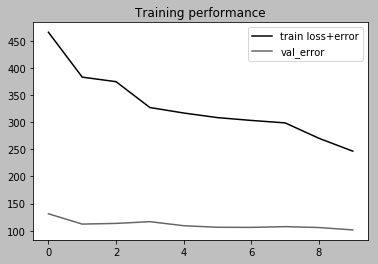

In [0]:
history = np.array(history)
plt.figure()
plt.title('Training performance')
plt.plot(history[:,0], history[:,1], label='train loss+error')
plt.plot(history[:,0], history[:,3], label='val_error')
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Valid Accuracy : 82.5000 %
              precision    recall  f1-score   support

           0       0.76      0.98      0.86        66
           1       0.97      0.63      0.76        54

    accuracy                           0.82       120
   macro avg       0.87      0.81      0.81       120
weighted avg       0.86      0.82      0.82       120



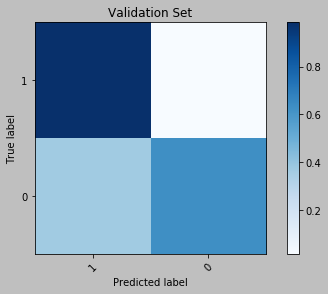

In [0]:
validate(valid_data , valid_labels , model , "ACL" )
 

## Abnormal Model

In [0]:
abnormal_model = MyModel()
abnormal_model.to(device)
history_abnormal = train(abnormal_model,X_train,y_train,10,X_test, y_test, disease = "Abnormal",lr = 0.0001)

Params to learn:
	 features_extractor.8.weight
	 features_extractor.8.bias
	 features_extractor.10.weight
	 features_extractor.10.bias
	 bn0.weight
	 bn0.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.2.weight
	 classifier.2.bias
MyModel(
  (features_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Validating Epoch 1 ...
Epoch [1/10], -T-Loss : 420.935589 , Train_accuracy: 0.8153 ,  Val_loss: 100.300998  -Val_acc: 0.7743
valid_acc has improved from -999.0000 to 0.7743, model is saved at drive/My Drive/Pattern Assignments/MRI-Ass4/Abnormal_base_model.h5
Validating Epoch 2 ...
Epoch [2/10], -T-Loss : 321.889533 , Train_accuracy: 0.8308 ,  Val_loss: 93.197589  -Val_acc: 0.8319
valid_acc has improved from 0.7743 to 0.8319, model is saved at drive/My Drive/Pattern Assignments/MRI-Ass4/Abnormal_base_model.h5
Validating Epoch 3 ...
Epoch [3/10], -T-Loss : 296.638395 , Train_accuracy: 0.8352 ,  Val_loss: 90.296462  -Val_acc: 0.8407
valid_acc has improved from 0.8319 to 0.8407, model is saved at drive/My Drive/Pattern Assignments/MRI-Ass4/Abnormal_base_model.h5
Validating Epoch 4 ...
Epoch [4/10], -T-Loss : 283.835899 , Train_accuracy: 0.8473 ,  Val_loss: 86.561910  -Val_acc: 0.8407
valid_acc has not Improved from 0.8407
Validating Epoch 5 ...
Epoch [5/10], -T-Loss : 270.175525 , Train_ac

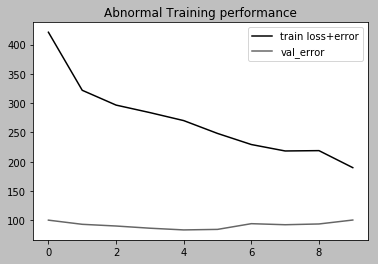

In [0]:
history_abnormal = np.array(history_abnormal)
plt.figure()
plt.title('Abnormal Training performance')
plt.plot(history_abnormal[:,0], history_abnormal[:,1], label='train loss+error')
plt.plot(history_abnormal[:,0], history_abnormal[:,3], label='val_error')
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Valid Accuracy : 87.5000 %
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1       0.89      0.96      0.92        95

    accuracy                           0.88       120
   macro avg       0.83      0.76      0.79       120
weighted avg       0.87      0.88      0.87       120



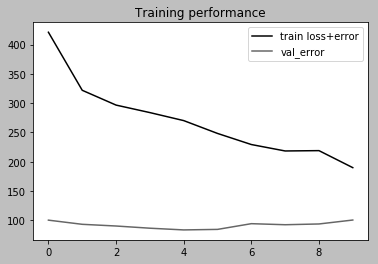

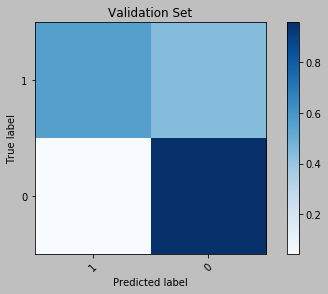

In [0]:
#abnormal_model.load_state_dict(torch.load('drive/My Drive/Pattern Assignments/MRI-Ass4/Abnormal_base_model.h5'))
validate(valid_data , valid_labels,abnormal_model , "Abnormal",history_abnormal)

## Meniscus Model

In [0]:
meniscus_model = MyModel()
meniscus_model.to(device)
history_meniscus = train(meniscus_model,X_train,y_train,10,X_test, y_test, disease = "Meniscus",lr = 0.0001)

Params to learn:
	 features_extractor.8.weight
	 features_extractor.8.bias
	 features_extractor.10.weight
	 features_extractor.10.bias
	 bn0.weight
	 bn0.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.2.weight
	 classifier.2.bias
MyModel(
  (features_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Validating Epoch 1 ...
Epoch [1/10], -T-Loss : 592.642217 , Train_accuracy: 0.6405 ,  Val_loss: 142.577352  -Val_acc: 0.6549
valid_acc has improved from -999.0000 to 0.6549, model is saved at drive/My Drive/Pattern Assignments/MRI-Ass4/Meniscus_base_model.h5
Validating Epoch 2 ...
Epoch [2/10], -T-Loss : 543.327260 , Train_accuracy: 0.6549 ,  Val_loss: 132.802440  -Val_acc: 0.6504
valid_acc has not Improved from 0.6549
Validating Epoch 3 ...
Epoch [3/10], -T-Loss : 513.804958 , Train_accuracy: 0.6814 ,  Val_loss: 127.565955  -Val_acc: 0.7345
valid_acc has improved from 0.6549 to 0.7345, model is saved at drive/My Drive/Pattern Assignments/MRI-Ass4/Meniscus_base_model.h5
Validating Epoch 4 ...
Epoch [4/10], -T-Loss : 489.811874 , Train_accuracy: 0.7257 ,  Val_loss: 124.596943  -Val_acc: 0.7434
valid_acc has improved from 0.7345 to 0.7434, model is saved at drive/My Drive/Pattern Assignments/MRI-Ass4/Meniscus_base_model.h5
Validating Epoch 5 ...
Epoch [5/10], -T-Loss : 476.150170 , Train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Valid Accuracy : 65.8333 %
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        68
           1       0.59      0.67      0.63        52

    accuracy                           0.66       120
   macro avg       0.66      0.66      0.66       120
weighted avg       0.67      0.66      0.66       120



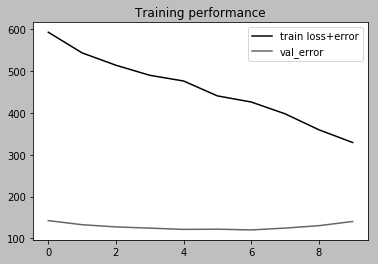

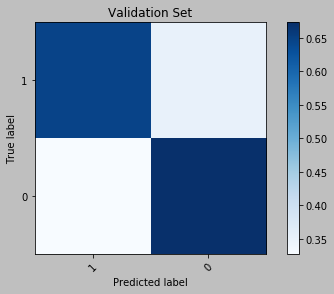

In [0]:
## Loading the Model
abnormal_model.load_state_dict(torch.load('drive/My Drive/Pattern Assignments/MRI-Ass4/Meniscus_base_model.h5'))
validate(valid_data , valid_labels,meniscus_model , "Meniscus",history_meniscus)

## Separate models for Feature extraction and Classification

In [0]:
def extract_features(data):
  feature_vectors = []
  feature_extraction_model = FeatureExtractorModel()
  feature_extraction_model.to(device)
  feature_vectors = []
  feature_extraction_model = feature_extraction_model.cuda()
  for stack in data : 
    x = stack
    x = np.stack((x,x,x), 1)
    test_tensor = torch.from_numpy(x)

    # Convert to FloatTensor first
    test_tensor = test_tensor.type(torch.FloatTensor)

    # Then call cuda() on test_tensor

    with torch.no_grad():
       test_tensor = test_tensor.cuda()
       log_results = feature_extraction_model.forward(test_tensor)

    feature_vectors.append(log_results)
    torch.cuda.empty_cache()
  return feature_vectors

In [0]:
torch.cuda.empty_cache()

In [0]:
valid_vectors = extract_features(valid_data)
training_vectors = extract_features(train_data)

In [0]:
training_vectors[5].shape

#### creating DataLoader and prepare the Data

In [0]:
import torch.utils.data as utils

tensor_y = torch.stack([torch.Tensor(i) for i in np.array(labels['Meniscus']).reshape(-1,1)])

my_dataset = utils.TensorDataset(torch.stack(training_vectors),tensor_y) # create your datset
train_dataloader = utils.DataLoader(my_dataset,batch_size=100, shuffle=False) # create your dataloader

tensor_y = torch.stack([torch.Tensor(i) for i in np.array(valid_labels['Meniscus']).reshape(-1,1)])

my_dataset = utils.TensorDataset(torch.stack(valid_vectors),tensor_y) # create your datset
valid_dataloader = utils.DataLoader(my_dataset,batch_size=20, shuffle=False) # create your dataloader



## Model Training

In [0]:
dense_model.to(device)
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classification_model.parameters(), lr=learning_rate) 
print(classification_model)

In [0]:
train_model(            train_dataloader,
            valid_dataloader,
            NUM_EPOCHS =50)

In [0]:
def train_model(train_dataloader,valid_dataloader,NUM_EPOCHS = 100,path='drive/MyDrive/Pattern Assignments/MRI-Ass4/model.h5' ):

  classification_model = 
  classification_model.to(device)
  learning_rate = 0.001
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(classification_model.parameters(), lr=learning_rate) 
  
  j=0
  running_loss,train_correct,val_acc = 0,0,-9999
  losses = []
  accu = []
  history = []
  print(classification_model)

  for i in range(NUM_EPOCHS):

    print('Training Epoch {} ...'.format(i+1))
    running_loss,train_correct,val_correct,val_loss = 0,0,0,0
    
    # Training for eboch
    for batch,y_true in train_dataloader:
      y_true= y_true.type(torch.FloatTensor)
      y_true = y_true.cuda()
     
      # Backward and optimize
      optimizer.zero_grad()
      y_pred = classification_model(batch)
      y_pred = y_pred.to(device)
      print(y_pred)
      train_correct +=(y_true.cpu().numpy() == np.around(y_pred.cpu().detach().numpy())).sum()

#       y_true= y_true.type(torch.FloatTensor)
#       y_true = y_true.cuda()
#       y_pred = y_pred.cuda()
      loss = criterion(y_pred, y_true)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      
    ## Validaition Step for each Eboch

    print('Validating Epoch {} ...'.format(i+1)) 
    
    for batch , y_true in valid_dataloader:

        y_true= y_true.type(torch.FloatTensor)
        y_true = y_true.cuda()
       

        # Backward and optimize
        optimizer.zero_grad()
        y_pred = classification_model(batch)
        y_pred = y_pred.to(device)
       
        val_correct +=(y_true.cpu().numpy() == np.around(y_pred.cpu().detach().numpy())).sum()
        
        y_true= y_true.type(torch.FloatTensor)
        y_true = y_true.cuda()
        y_pred = y_pred.cuda()
        loss = criterion(y_pred, y_true)
        val_loss += loss.item()




    test_accu =  int(train_correct) / len(training_vectors)
    valid_accu = int(val_correct) / 120

    print ('Epoch [{}/{}], -T-Loss : {:.6f} , Train_accuracy: {:.4f} ,  Val_loss: {:.6f}  -Val_acc: {:.4f}'.format(i+1, NUM_EPOCHS,running_loss,test_accu ,val_loss, valid_accu))

    if val_acc < valid_accu:
     # torch.save(classification_model.state_dict(), path)
      print('val_acc has improved from {:.4f} to {:.4f}, model is saved at {}'.format(val_acc , valid_accu,path))
      val_acc = valid_accu
    else:
      print('val_acc has not Improved from {:.4f}'.format(val_acc))    
    history.append([i,running_loss,val_acc,val_loss])

    #accu.append(100 * int(test_correct) / len(X_test))


### Helper functions